## Graph Attention Networks: Self Attention for GNNs

Source: https://mlabonne.github.io/blog/posts/2022-03-09-Graph_Attention_Network.html

In [1]:
import torch
import numpy as np 
np.random.seed(0)
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size':24})

In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

print(f'Number of graphs: {len(dataset)}')
print(f'Number of Nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has Isolated nodes: {data.has_isolated_nodes()}')

Number of graphs: 1
Number of Nodes: 3327
Number of features: 3703
Number of classes: 6
Has Isolated nodes: True


<BarContainer object of 32 artists>

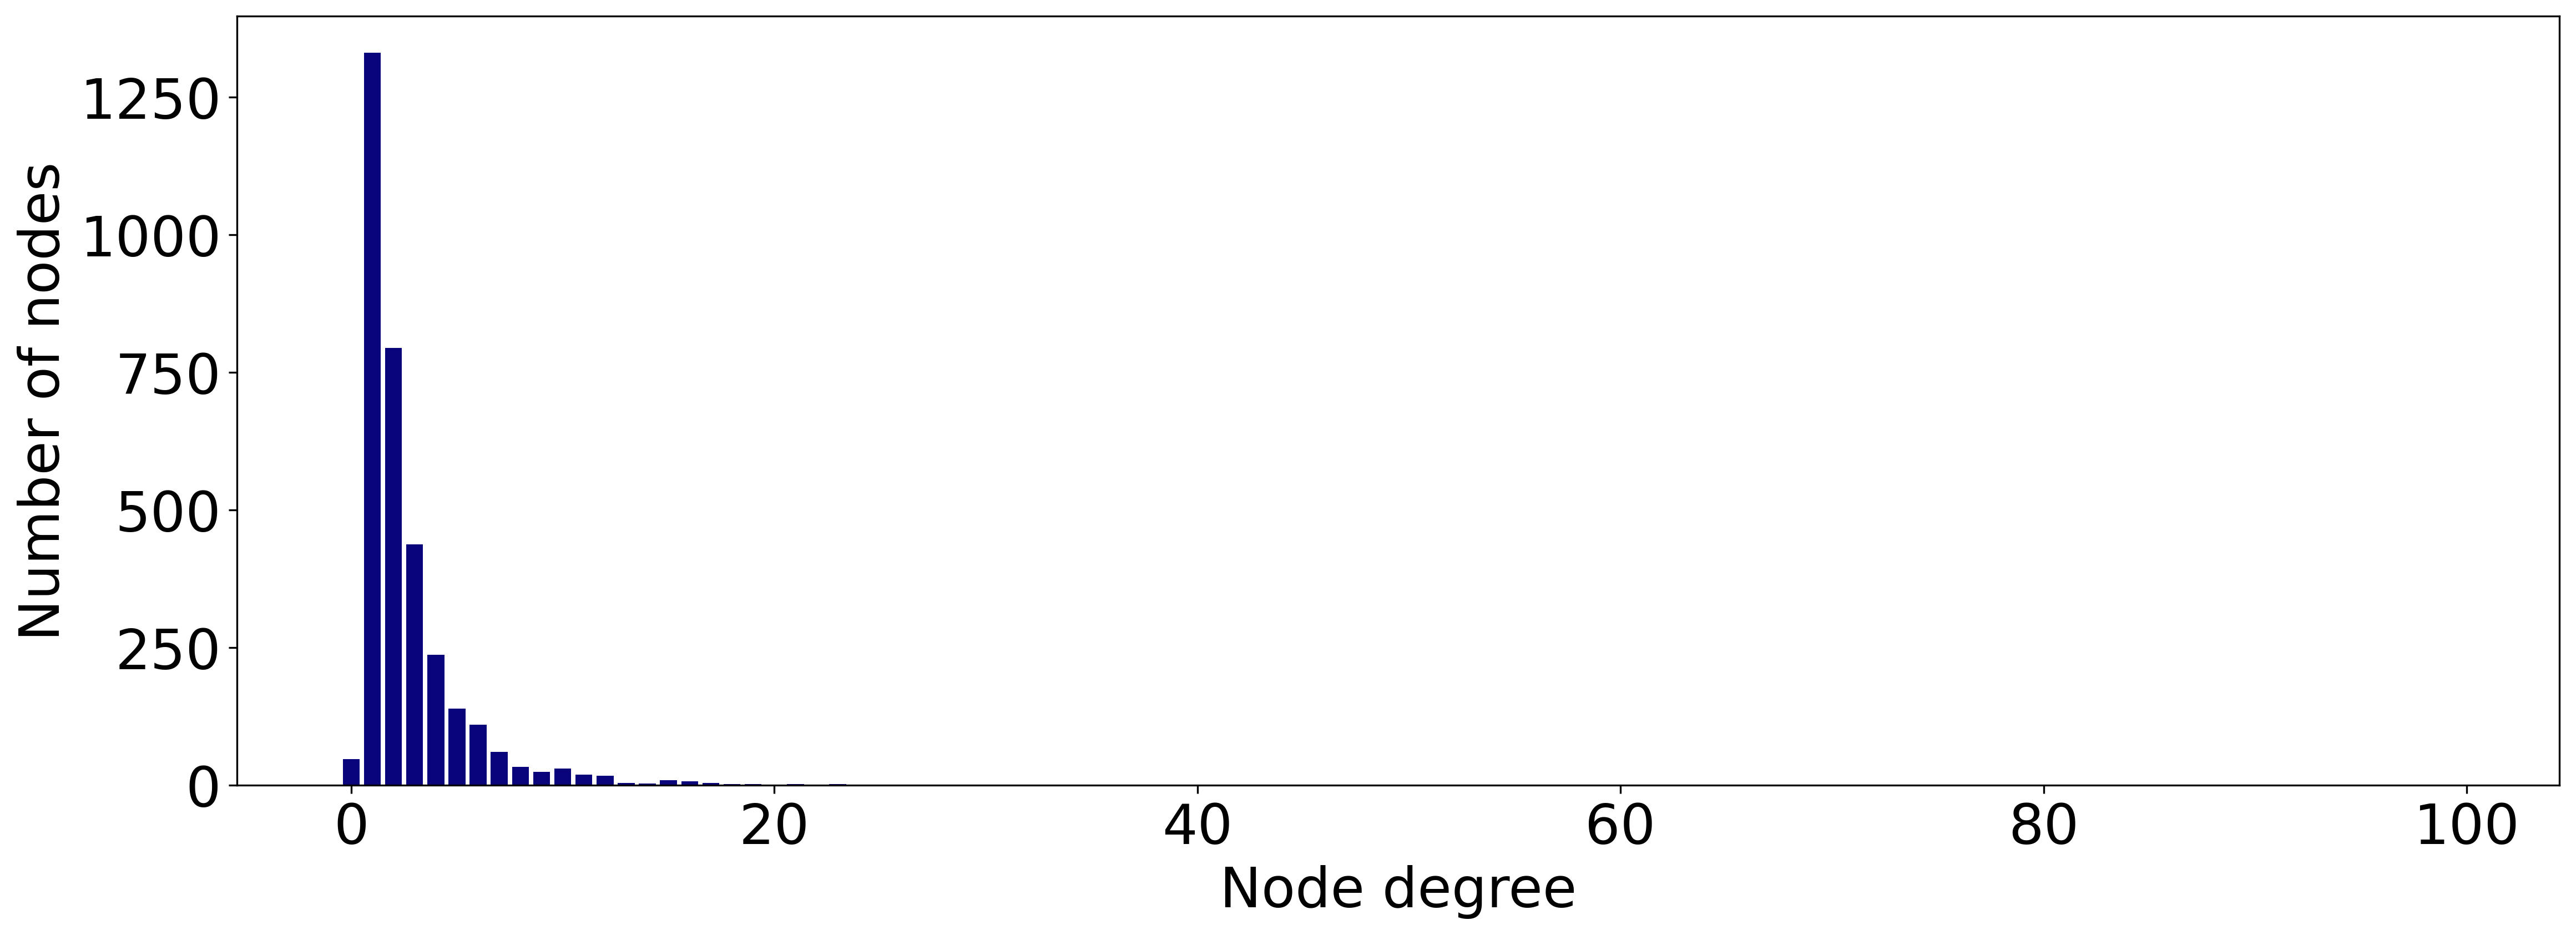

In [4]:
# Plotting the number of connections of each node with degree
from torch_geometric.utils import degree
from collections import Counter

degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)

fig, ax = plt.subplots(figsize=(18,6))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [8]:
import torch.nn.functional as F 
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)
    
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads = heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads = 1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)
        
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)
    
def accuracy(pred_y, y):
    return((pred_y == y).sum()/len(y)).item()

def train(model, data):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model. train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        if (epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            
    return model

@torch.no_grad()
def test(model, data):
    model.eval()
    _,out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [9]:
# GCN Model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

train(gcn, data)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.801 | Train Acc:  14.17% | Val Loss: 1.80 | Val Acc: 13.40%
Epoch  10 | Train Loss: 0.400 | Train Acc:  98.33% | Val Loss: 1.26 | Val Acc: 59.40%
Epoch  20 | Train Loss: 0.107 | Train Acc:  99.17% | Val Loss: 1.34 | Val Acc: 54.20%
Epoch  30 | Train Loss: 0.061 | Train Acc:  99.17% | Val Loss: 1.40 | Val Acc: 59.20%
Epoch  40 | Train Loss: 0.039 | Train Acc: 100.00% | Val Loss: 1.53 | Val Acc: 56.20%
Epoch  50 | Train Loss: 0.061 | Train Acc:  97.50% | Val Loss: 1.60 | Val Acc: 58.00%
Epoch  60 | Train Loss: 0.044 | Train Acc: 100.00% | Val Loss: 1.50 | Val Acc: 59.60%
Epoch  70 | Train Loss: 0.052 | Train Acc:  99.17% | Val Loss: 1.55 | Val Acc: 57.60%
Epoch  80 | Train Loss: 0.030 | Train Acc: 100.00% | Val Loss: 1.72 | Val Acc: 57.40%
Epoch  90 | Train Loss: 0.058 | Train Acc:  98.33% | Val Loss: 1.48 | Val Acc: 59.80%
Epoch 100 | Train Loss: 0.029 | Train Acc: 100.00% | Val Loss: 1.53 | Val Acc: 5

In [10]:
# GAT Model
gat = GAT(data.num_features, 8, dataset.num_classes)
print(gat)

train(gat, data)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.788 | Train Acc:  15.83% | Val Loss: 1.77 | Val Acc: 20.80%
Epoch  10 | Train Loss: 0.098 | Train Acc:  98.33% | Val Loss: 1.03 | Val Acc: 65.40%
Epoch  20 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 1.23 | Val Acc: 64.60%
Epoch  30 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.33 | Val Acc: 64.60%
Epoch  40 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 1.24 | Val Acc: 63.60%
Epoch  50 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 64.60%
Epoch  60 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 1.23 | Val Acc: 65.20%
Epoch  70 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.16 | Val Acc: 67.40%
Epoch  80 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.15 | Val Acc: 66.40%
Epoch  90 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.15 | Val Acc: 67.20%
Epoch 100 | Train Loss: 0.007 | Train Acc: 100.00% | Val Lo

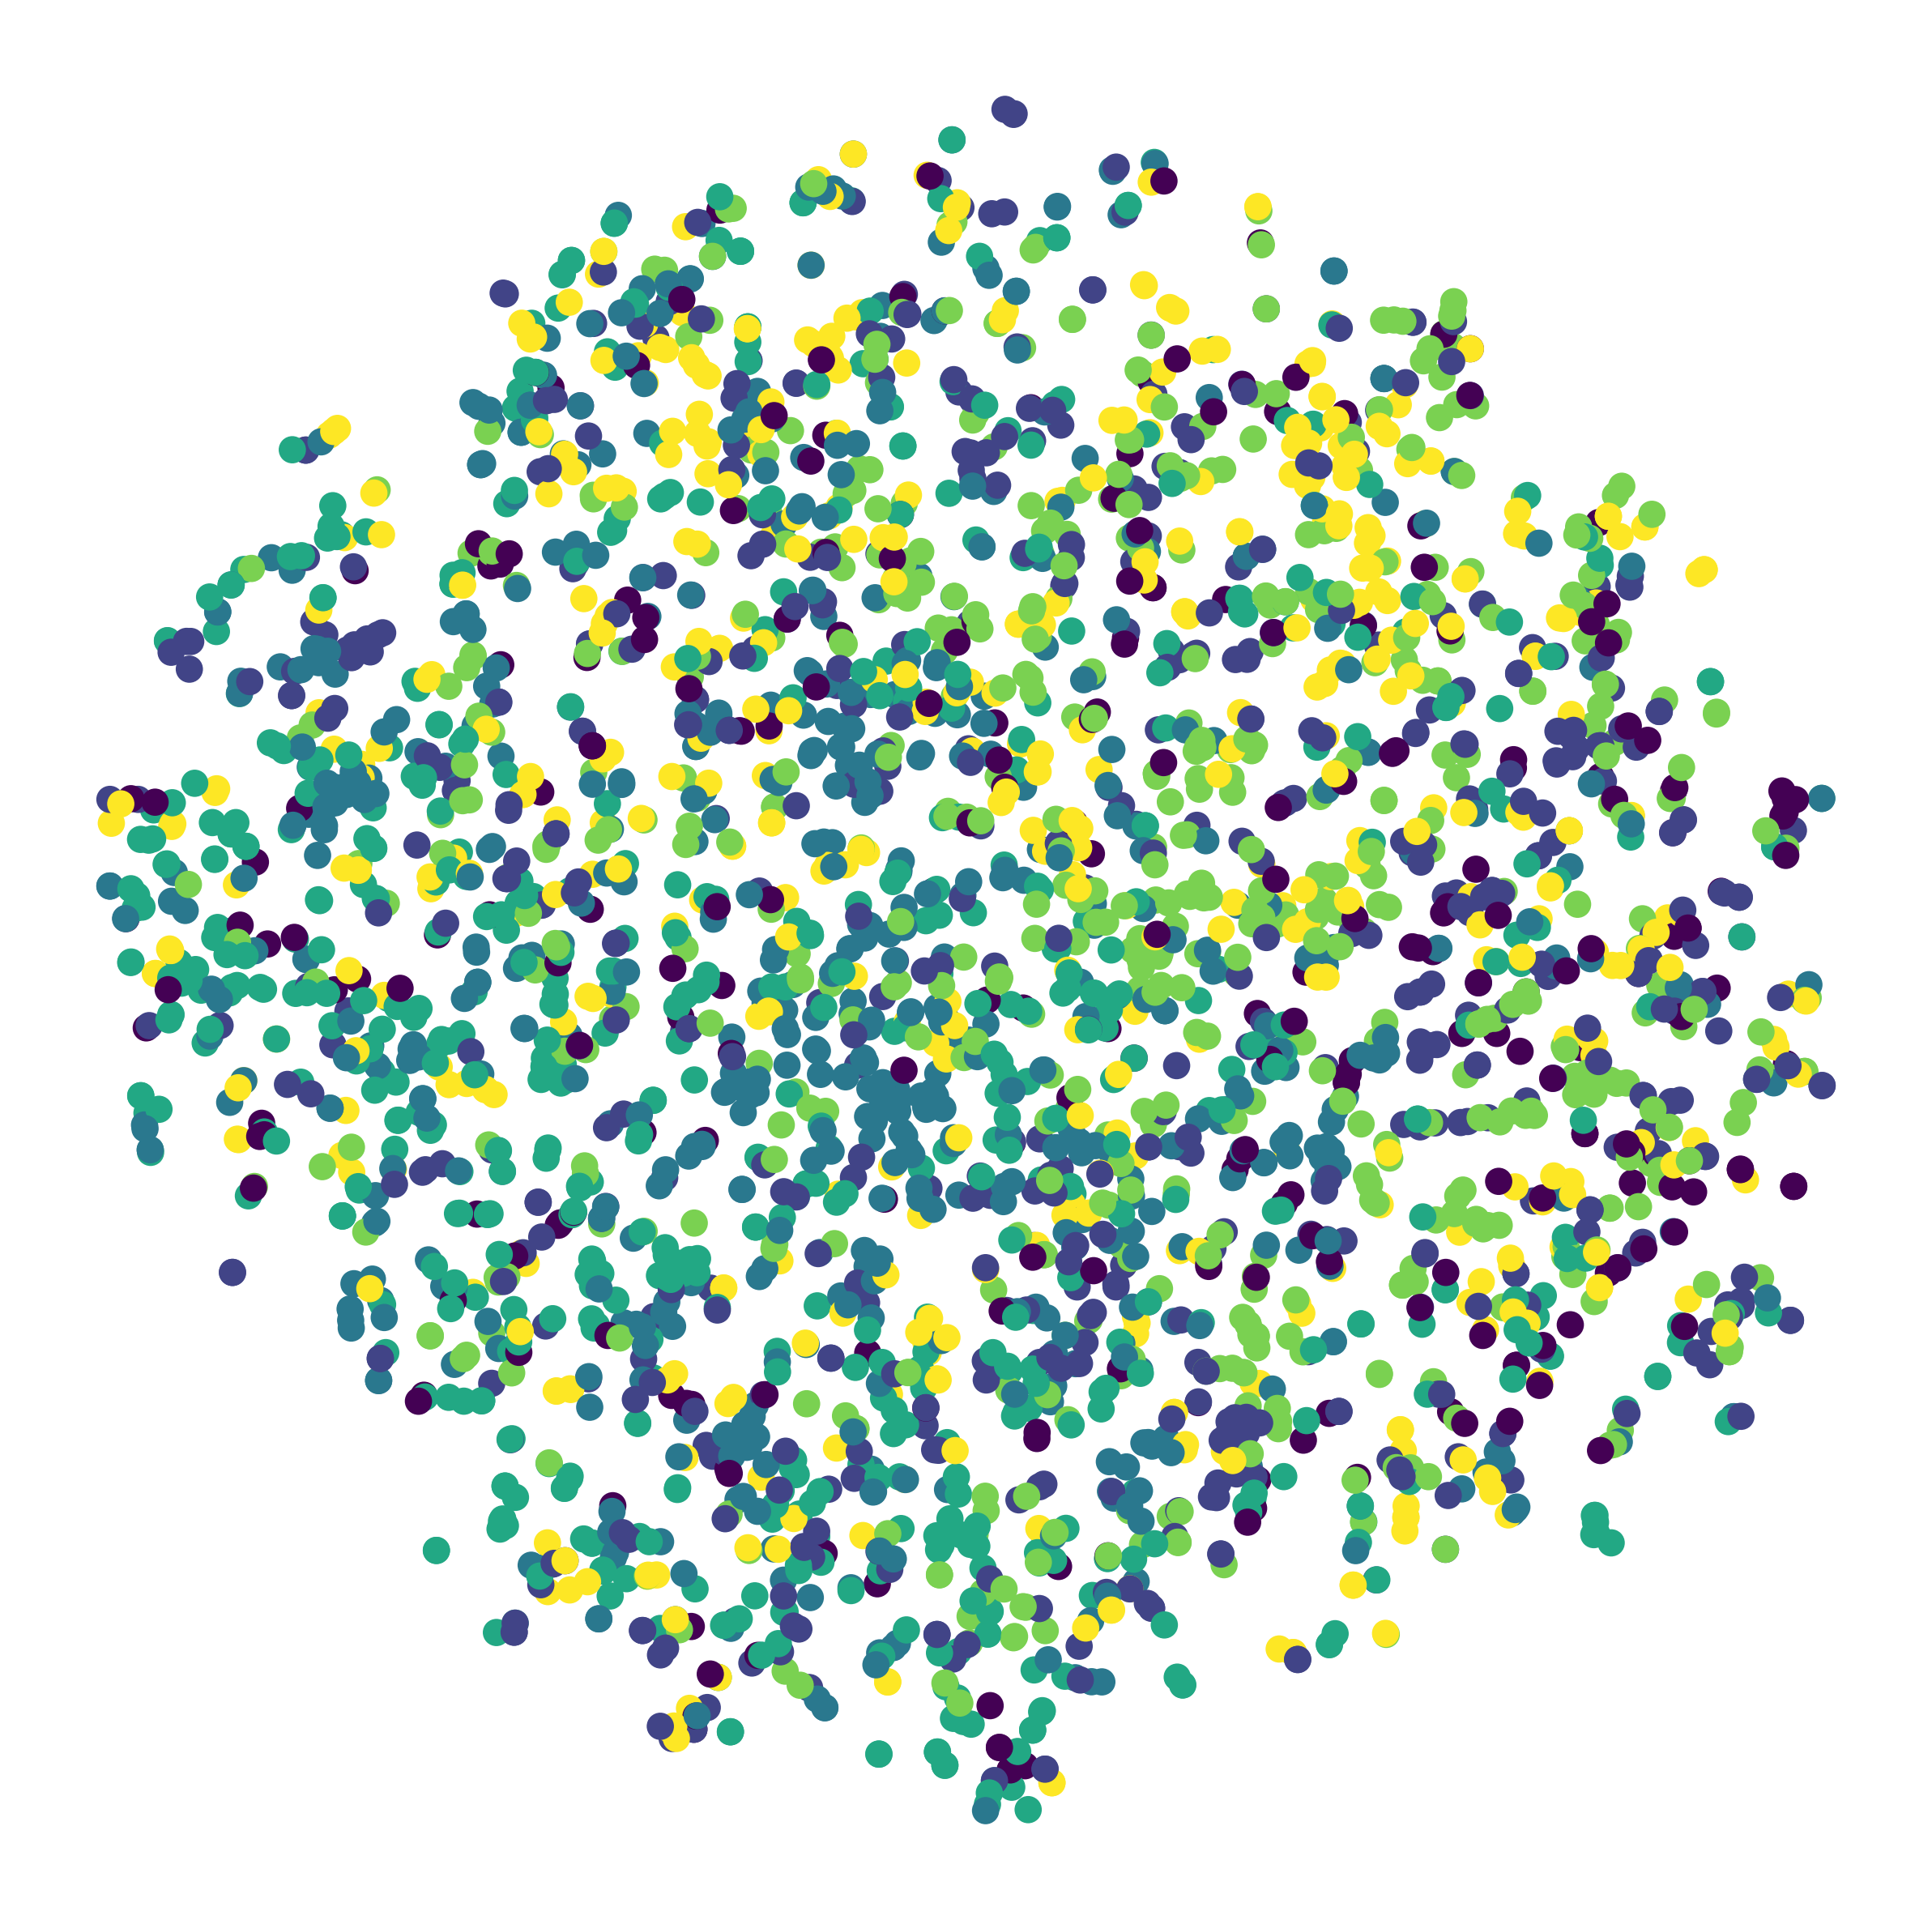

In [11]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

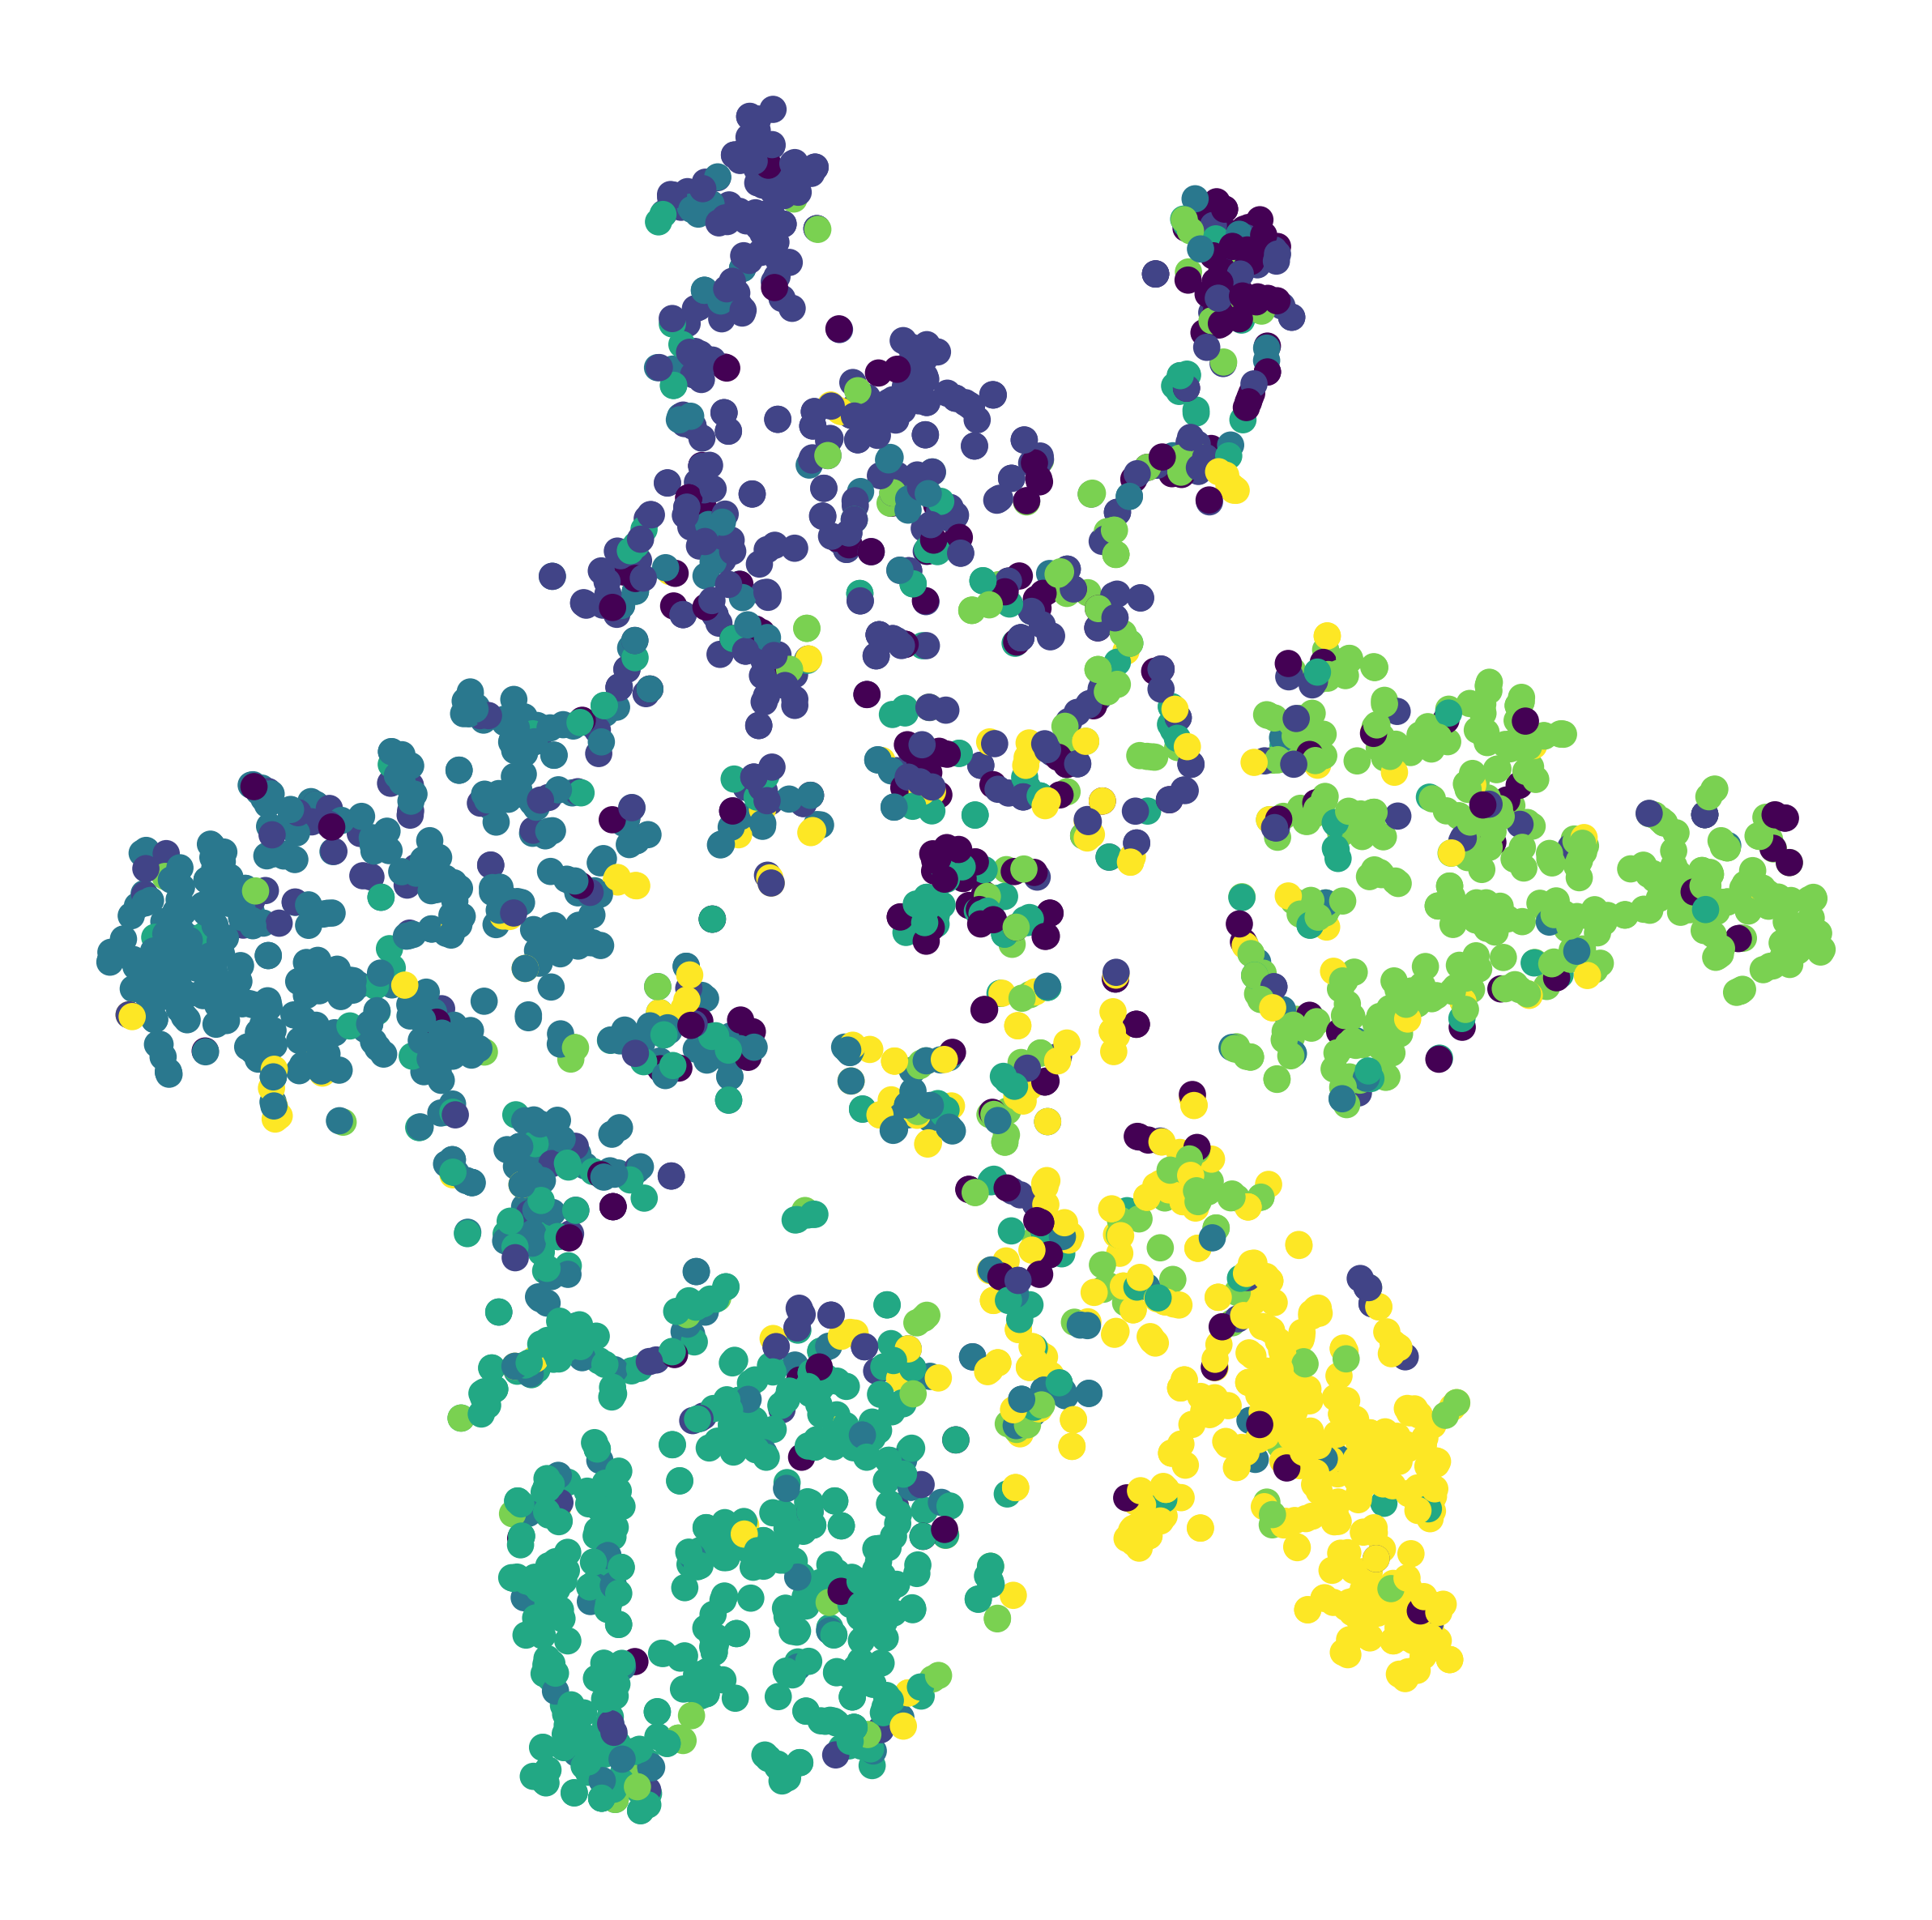

In [12]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

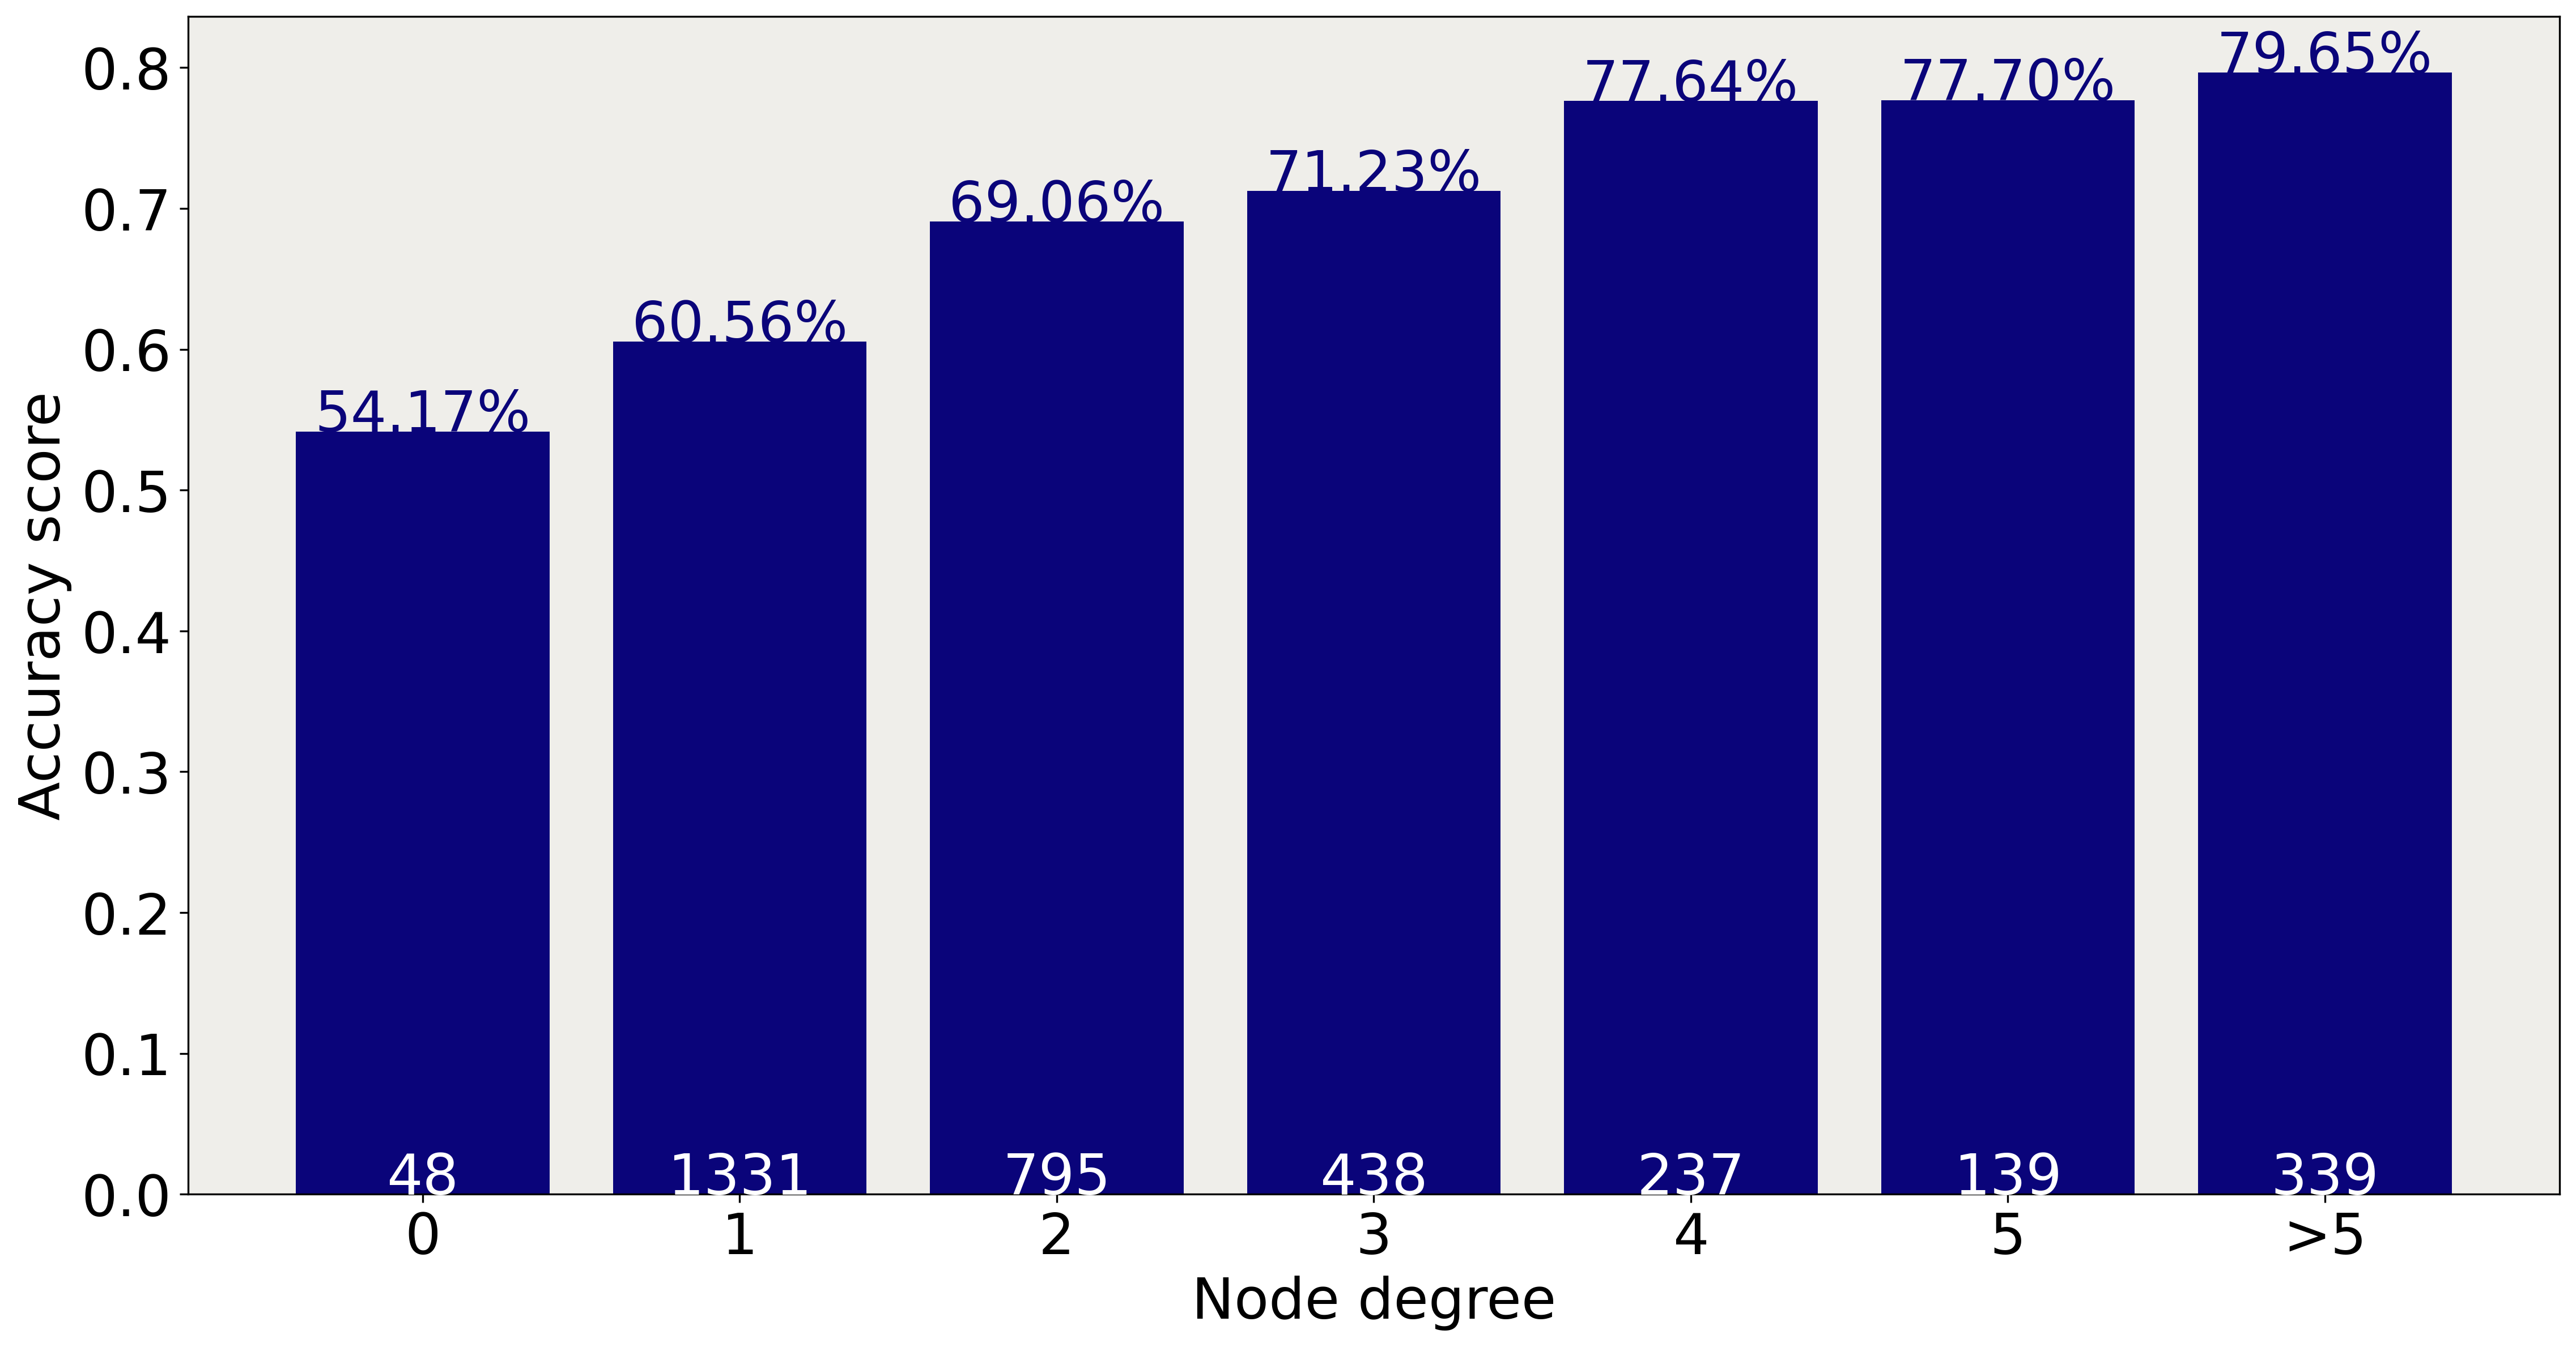

In [13]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
ax.set_facecolor('#EFEEEA')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')